# Causal graph

[{'A': 0, 'B': 0, 'C': 1, 'D': 0}, {'A': 0, 'B': 0, 'C': 0, 'D': 1}, {'A': 1, 'B': 0, 'C': 0, 'D': 0}, {'A': 0, 'B': 0, 'C': 1, 'D': 0}, {'A': 0, 'B': 0, 'C': 1, 'D': 0}, {'A': 0, 'B': 0, 'C': 0, 'D': 0}, {'A': 1, 'B': 1, 'C': 1, 'D': 1}, {'A': 1, 'B': 1, 'C': 0, 'D': 1}, {'A': 0, 'B': 1, 'C': 0, 'D': 1}, {'A': 0, 'B': 0, 'C': 1, 'D': 0}]
{'A': 0.3, 'B': 0.3, 'C': 0.5, 'D': 0.4}
{('A', 'B'): 0.2, ('B', 'A'): 0.2, ('A', 'C'): 0.1, ('C', 'A'): 0.1, ('B', 'D'): 0.3, ('D', 'B'): 0.3, ('A', 'D'): 0.11338496208569517, ('D', 'A'): 0.11338496208569517, ('B', 'C'): 3.9178734724334032, ('C', 'B'): 3.9178734724334032, ('C', 'D'): 3.2542712891302465, ('D', 'C'): 3.2542712891302465}
{('A', 'B'), ('A', 'C'), ('B', 'D')}
Target node: A
1-hop neighbors of A: {'B', 'C'}
2-hop neighbors of A: {'D'}
Out of neighborhood of A: set()
Is there a path from A to D? False
Can there be an unobserved path from A to D? True
All nodes reachable from A via paths: {'B', 'C', 'D', 'A'}


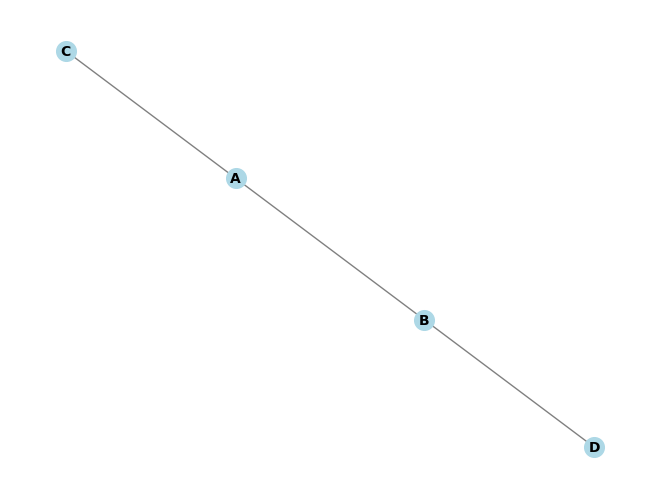

In [1]:
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

class CausalGraph:
    def __init__(self, V, path=[], unobserved_edges=[]):
        self.v = list(V)
        self.set_v = set(V)
        self.fn = {v: set() for v in V}  # First neighborhood
        self.sn = {v: set() for v in V}  # Second neighborhood
        self.on = {v: set() for v in V}  # Out of neighborhood
        self.p = set(map(tuple, map(sorted, path)))  # Path to First neighborhood
        self.ue = set(map(tuple, map(sorted, unobserved_edges)))  # Unobserved edges

        for v1, v2 in path:
            self.fn[v1].add(v2)
            self.fn[v2].add(v1)
            self.p.add(tuple(sorted((v1, v2))))

    def __iter__(self):
        return iter(self.v)

    def categorize_neighbors(self,target_node):
        # centrality = {v: len(self.fn[v]) for v in self.v}
        # target_node = max(centrality, key=centrality.get)
        if target_node not in self.set_v:
            return

        one_hop_neighbors = self.fn[target_node]
        two_hop_neighbors = set()

        for neighbor in one_hop_neighbors:
            two_hop_neighbors |= self.fn[neighbor]

        two_hop_neighbors -= one_hop_neighbors
        two_hop_neighbors.discard(target_node)
        out_of_neighborhood = self.set_v - (one_hop_neighbors | two_hop_neighbors | {target_node})

        self.sn[target_node] = two_hop_neighbors
        self.on[target_node] = out_of_neighborhood
        return target_node, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood

    def plot(self):
        G = nx.Graph()
        G.add_nodes_from(self.v)
        G.add_edges_from(self.p)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=200, font_size=10, font_weight='bold', node_color="lightblue", edge_color="grey")
        plt.savefig('causal.png')
        plt.show()

    def sort(self):
        sorted_nodes = sorted(list(self.set_v))
        return sorted_nodes

    def graph_search(self,cg, v1, v2=None, edge_type="path",target_node = None):
        assert edge_type in ["path", "unobserved"]
        assert v1 in cg.set_v
        assert v2 in cg.set_v or v2 is None

        target, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood = cg.categorize_neighbors(target_node)

        q = deque([v1])
        seen = {v1}
        while len(q) > 0:
            cur = q.popleft()
            cur_fn = cg.fn[cur]
            cur_sn = cg.sn[target_node]
            cur_on = cg.on[target_node]

            cur_neighbors = cur_fn if edge_type == "path" else (cur_sn | cur_on)

            for neighbor in cur_neighbors:
                if neighbor not in seen:
                    if v2 is not None:
                        if (neighbor == v2 and edge_type == "path" and neighbor in one_hop_neighbors) or \
                                (neighbor == v2 and edge_type == "unobserved" and neighbor in (
                                        two_hop_neighbors | out_of_neighborhood)):
                            return True
                    seen.add(neighbor)
                    q.append(neighbor)

        if v2 is None:
            return seen

        return False

    def generate_binary_values(self, cg, num_samples):
        dataset = []
        for _ in range(num_samples):
            binary_values = {node: random.choice([0, 1]) for node in cg}
            dataset.append(binary_values)
        return dataset

    def calculate_probabilities(self, dataset):
        node_counts = {node: 0 for node in self.v}
        total_samples = len(dataset)

        for i in dataset:
            for node, value in i.items():
                if value == 1:
                    node_counts[node] += 1

        node_probabilities = {node: count / total_samples for node, count in node_counts.items()}
        return node_probabilities

    def calculate_joint_probabilities(self, dataset):
        joint_counts = {(node_i, node_j): 0 for node_i in self.v for node_j in self.v if node_i != node_j}
        total_samples = len(dataset)

        for sample in dataset:
            for node_i, node_j in joint_counts.keys():
                if sample[node_i] == 1 and sample[node_j] == 1:
                    joint_counts[(node_i, node_j)] += 1

        joint_probabilities = {}
        min_prob = 1  # initialize the min_prob to 1

        # First, calculate the probabilities for the existing links
        for (node_i, node_j), count in joint_counts.items():
            if (node_i, node_j) in self.p or (node_j, node_i) in self.p:
                prob = count / total_samples
                joint_probabilities[(node_i, node_j)] = prob
                joint_probabilities[(node_j, node_i)] = prob  # update for bidirectional link
                if prob < min_prob:
                    min_prob = prob  # update the minimum probability

        # Now, calculate the probabilities for the non-existing links using the Gumbel distribution
        for (node_i, node_j), count in joint_counts.items():
            if (node_i, node_j) not in self.p and (node_j, node_i) not in self.p:
                # generate a random value from a Gumbel distribution
                gumbel_noise = np.random.gumbel()
                # rescale the gumbel noise to be in [0, min_prob)
                # scaled_gumbel_noise = min_prob * (gumbel_noise - np.min(gumbel_noise)) / (np.max(gumbel_noise) - np.min(gumbel_noise))
                joint_probabilities[(node_i, node_j)] = gumbel_noise
                joint_probabilities[(node_j, node_i)] = gumbel_noise  # update for bidirectional link

        return joint_probabilities

if __name__ == "__main__":
    cg = CausalGraph(['A', 'B', 'C', 'D'], [('A', 'B'), ('A', 'C'), ('B', 'D')])
    datasets = cg.generate_binary_values(cg,num_samples=10)
    p_v = cg.calculate_probabilities(datasets)
    print(datasets)
    p_v_joint = cg.calculate_joint_probabilities(datasets)
    print(p_v)
    print(p_v_joint)
    print(cg.p)

    target_node, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood = cg.categorize_neighbors(target_node = cg.sort()[0])
    print(f"Target node: {target_node}")
    print(f"1-hop neighbors of A: {one_hop_neighbors}")
    print(f"2-hop neighbors of A: {two_hop_neighbors}")
    print(f"Out of neighborhood of A: {out_of_neighborhood}")
    # Example usage of graph_search
    result1 = cg.graph_search(cg, 'A', 'D', edge_type="path",target_node = 'A')
    print(f"Is there a path from A to D? {result1}")
    result2 = cg.graph_search(cg, 'A', 'D', edge_type="unobserved",target_node = 'A')
    print(f"Can there be an unobserved path from A to D? {result2}")
    result3 = cg.graph_search(cg, 'A', edge_type="path",target_node = 'A')
    print(f"All nodes reachable from A via paths: {result3}")
    cg.plot()

# Algorithm 1

[{'A': 0, 'B': 1, 'C': 1, 'D': 0}, {'A': 1, 'B': 0, 'C': 1, 'D': 0}, {'A': 1, 'B': 1, 'C': 1, 'D': 0}, {'A': 1, 'B': 0, 'C': 1, 'D': 0}, {'A': 1, 'B': 0, 'C': 0, 'D': 1}, {'A': 0, 'B': 0, 'C': 0, 'D': 1}, {'A': 0, 'B': 1, 'C': 0, 'D': 1}, {'A': 0, 'B': 1, 'C': 1, 'D': 1}, {'A': 0, 'B': 0, 'C': 1, 'D': 0}, {'A': 0, 'B': 0, 'C': 1, 'D': 1}] 
 {'A': 0.4, 'B': 0.4, 'C': 0.7, 'D': 0.5} 
 {('A', 'B'): 0.1, ('B', 'A'): 0.1, ('A', 'C'): 0.3, ('C', 'A'): 0.3, ('B', 'D'): 0.2, ('D', 'B'): 0.2, ('A', 'D'): 0.2878856291267668, ('D', 'A'): 0.2878856291267668, ('B', 'C'): 0.49441359569410936, ('C', 'B'): 0.49441359569410936, ('C', 'D'): 1.1064401463716462, ('D', 'C'): 1.1064401463716462}
Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.01
The loss value is :  [0.33541932702064514] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.05
The loss value is :  [0.10991257429122925] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.1
The

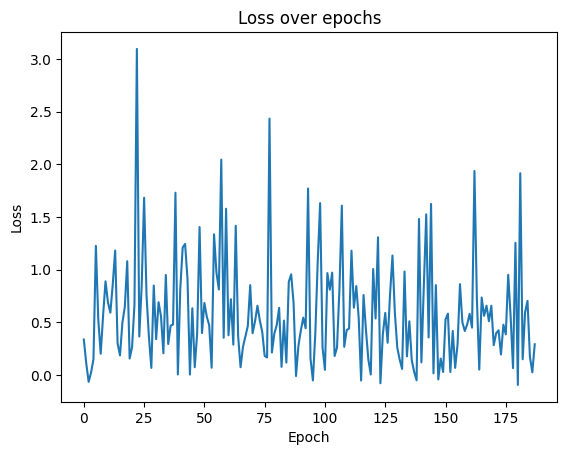

In [3]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Uniform, Gumbel, Bernoulli
import matplotlib.pyplot as plt
from itertools import product
import os
import numpy as np

class NNModel(nn.Module):
    def __init__(self, u, input_size, output_size, h_size, h_layers):
        super(NNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.h_size = h_size
        self.h_layers = h_layers
        self.u = u
        layers = [nn.Linear(self.input_size, self.h_size)]
        for l in range(h_layers - 1):
            layers.append(nn.Linear(self.h_size, self.h_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.h_size, self.output_size))
        self.nn = nn.Sequential(*layers)
        self.nn.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, gain=torch.nn.init.calculate_gain('relu'))

    def nn_forward(self):
        out = self.nn(self.u)
        return torch.sigmoid(out)

class NCM:
    def __init__(self, graph, lambda_reg, learning_rate,h_size, h_layers):
        self.graph = graph
        self.h_size = h_size
        self.h_layers = h_layers
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.states = {graph.target_node: Bernoulli(0.5).sample((1,))}
        self.u_i = {v: Uniform(0, 1).sample((1,)) for v in graph.one_hop_neighbors | graph.two_hop_neighbors}
        self.u_ij = {v: Uniform(0, 1).sample((1,)) for v in graph.one_hop_neighbors}
        self.u_do = {v: Uniform(0, 1).sample((1,)) for v in graph.one_hop_neighbors}
        self.u = torch.cat(list(self.states.values()) + list(self.u_i.values()) + list(self.u_ij.values()), dim=0)
        self.model_v = NNModel(u = self.u, input_size=len(self.u), output_size=1,h_size = self.h_size, h_layers = self.h_layers)
        self.model_do = NNModel(u = self.u, input_size=len(self.u), output_size=1,h_size = self.h_size, h_layers = self.h_layers)

    def ncm_forward(self):
        G_i = Gumbel(loc=torch.tensor([0.0]), scale=torch.tensor([1.0])).sample((1,))
        f = self.model_v.nn_forward()
        # print(self.states)
        if len(self.u_ij) > 0:
            return G_i + torch.log(f)
        else:
            return G_i + torch.log(1 - f)

def train(cg,lambdas,learning_rate,h_size,h_layers,num_epochs):
    causal_loss = []
    losses = []
    for i in range(num_epochs):
        # print('epoch : ', i)
        sum_f = 0
        for node in cg.set_v:
            # print(node)
            cg.target_node, cg.one_hop_neighbors, cg.two_hop_neighbors, cg.out_of_neighborhood = cg.categorize_neighbors(target_node=node)
            ncm = NCM(cg, lambda_reg=lambdas, learning_rate=learning_rate, h_size=h_size, h_layers=h_layers)
            optimizer = optim.Adam(ncm.model_v.parameters(), lr=ncm.learning_rate)
            optimizer.zero_grad()
            f = ncm.ncm_forward()
            # print(f)
            sum_f += f
        # print(sum_f)
        p_L1 = sum_f / len(cg.set_v)
        p_L2 = torch.abs(torch.prod(p_L1) / len(cg.set_v))
        # loss = -np.log(torch.sum(p_L1))
        loss = ((1 / len(cg.set_v)) * -torch.log(torch.sum(p_L1))) - (lambdas * torch.log(torch.sum(p_L2)))
        # print(loss)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
        dir_path = "./model"
        os.makedirs(dir_path, exist_ok=True)
        torch.save(ncm.model_v.state_dict(), os.path.join(dir_path, f'model_{i}.pth'))
    # print(losses)
    if math.isnan(losses[0]):
        causal_loss.append(losses[1])
    else:
        causal_loss.append(losses[0])
    print("The loss value is : ", causal_loss, '\n')
    return causal_loss

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

if __name__ == "__main__":
    cg = CausalGraph(['A', 'B', 'C', 'D'], [('A', 'B'), ('A', 'C'), ('B', 'D')])
    cg.target_node, cg.one_hop_neighbors, cg.two_hop_neighbors, cg.out_of_neighborhood = cg.categorize_neighbors(target_node=cg.sort()[0])
    datasets = cg.generate_binary_values(cg, num_samples=10)
    p_v = cg.calculate_probabilities(datasets)
    p_v_joint = cg.calculate_joint_probabilities(datasets)
    print(datasets,'\n',p_v,'\n',p_v_joint)

    # hyperparameters
    num_epochs = 2
    learning_rates = [0.001, 0.002, 0.005,0.01]
    hidden_sizes = [32, 64, 128, 256]
    num_layers = [1, 2, 3, 4]
    lambdas = [0.01, 0.05, .1,.2,.3]
    hyperparameters = product(learning_rates, hidden_sizes, num_layers, lambdas)
    total_loss = []
    for i, hyperparams in enumerate(hyperparameters):
        learning_rate, h_size, h_layers, lambdas = hyperparams
        print(f'Training with learning rate: {learning_rate}, h_size: {h_size}, h_layers: {h_layers}, lambdas: {lambdas}')
        causal_loss = train(cg, lambdas, learning_rate, h_size, h_layers, num_epochs)
        total_loss.append(causal_loss)
    total_loss = [x for x in total_loss if not math.isnan(x[0])]
    print(total_loss)

    plt.figure()
    plt.plot(total_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.savefig('syn Loss over epochs.png')

# Algorithm 3

Streaming output truncated to the last 5000 lines.
The loss value is :  [0.3878481686115265] 

The loss value is :  [0.3878481686115265] 

This is group: 1446.0 and this is first subgraph 
Target node: 10836
1-hop neighbors of A: {10841}
2-hop neighbors of A: {10842}
Out of neighborhood of A: {10840, 10837, 10838, 10839}
The loss value is :  [0.4989898204803467] 

The loss value is :  [0.4989898204803467] 

This is group: 1447.0 and this is first subgraph 
Target node: 10840
1-hop neighbors of A: {10841, 10844}
2-hop neighbors of A: {10842, 10843}
Out of neighborhood of A: {10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10856, 10857, 10858, 10859, 10845, 10846, 10847}
The loss value is :  [0.5768148899078369] 

The loss value is :  [0.5768148899078369] 

This is group: 1448.0 and this is first subgraph 
Target node: 10859
1-hop neighbors of A: {10860, 10861, 10862}
2-hop neighbors of A: {10864, 10865, 10863}
Out of neighborhood of A: set()
The loss value is :  [nan] 

The loss

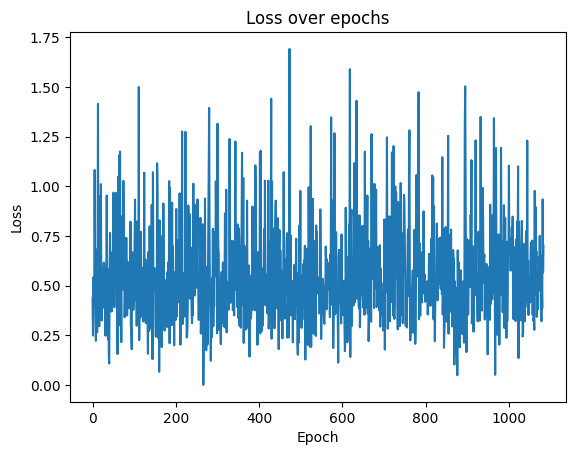

The time of the calculation was :  226.50465965270996


In [6]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import torch
import time

def GNNCausalExplanation(dataset, lambdas, learning_rate, h_size, h_layers, num_epochs, delta):
    total_loss = []
    for graph_id in dataset:
        cg = dataset[graph_id]
        v_star, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood = cg.categorize_neighbors(target_node=cg.sort()[0])
        print(f"This is group: {graph_id} and this is first subgraph ")
        print(f"Target node: {v_star}")
        print(f"1-hop neighbors of A: {one_hop_neighbors}")
        print(f"2-hop neighbors of A: {two_hop_neighbors}")
        print(f"Out of neighborhood of A: {out_of_neighborhood}")
        causal_loss = train(cg, lambdas = lambdas, learning_rate = learning_rate, h_size = h_size, h_layers = h_layers, num_epochs = num_epochs)
        print("The loss value is : ",causal_loss,'\n')
        total_loss.append(causal_loss)
    total_loss = [x for x in total_loss if not math.isnan(x[0])]
    print(total_loss)

    plt.figure()
    plt.plot(total_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.savefig('alg3 NCM Loss over epochs.png')
    plt.show()

if __name__ == "__main__":
    start_time1 = time.time()
    AIDS = "/content/drive/MyDrive/data/AIDS/"
    AIDS_df = pd.read_csv(AIDS + 'AIDS_A.txt', sep=',', header=None, names=['from', 'to'])
    AIDS_graph_indicator = pd.read_csv(AIDS + 'AIDS_graph_indicator.txt', header=None, names=['graph_id'])
    AIDS_node_labels = pd.read_csv(AIDS + 'AIDS_node_labels.txt', header=None, names=['node_label'])
    AIDS_df['graph_id'] = AIDS_graph_indicator
    AIDS_df['node_label'] = AIDS_node_labels
    grouped = AIDS_df.groupby('graph_id')
    AIDS_causal_graphs = {}
    for graph_id, group in grouped:
        V = set(group['from']).union(set(group['to']))
        edges = list(zip(group['from'], group['to'])) + list(zip(group['to'], group['from']))
        AIDS_causal_graphs[graph_id] = CausalGraph(V=V, path=edges)

    Mutagenicity = "/content/drive/MyDrive/data/Mutagenicity/"
    Mutagenicity_df = pd.read_csv(Mutagenicity + 'Mutagenicity_A.txt', sep=',', header=None, names=['from', 'to'])
    Mutagenicity_graph_indicator = pd.read_csv(Mutagenicity + 'Mutagenicity_graph_indicator.txt', header=None,names=['graph_id'])
    Mutagenicity_node_labels = pd.read_csv(Mutagenicity + 'Mutagenicity_node_labels.txt', header=None,names=['node_label'])
    Mutagenicity_df['graph_id'] = Mutagenicity_graph_indicator
    Mutagenicity_df['node_label'] = Mutagenicity_node_labels
    grouped = Mutagenicity_df.groupby('graph_id')
    Mutagenicity_causal_graphs = {}
    for graph_id, group in grouped:
        V = set(group['from']).union(set(group['to']))
        edges = list(zip(group['from'], group['to'])) + list(zip(group['to'], group['from']))
        Mutagenicity_causal_graphs[graph_id] = CausalGraph(V=V, path=edges)
    end_time1 = time.time()
    t1 = end_time1 - start_time1
    print('The time of the data preprocessing was : ', t1)

    num_subgraph_limit = 5
    delta = 0.01
    num_nodes_density = 5
    start_time2 = time.time()
    GNNCausalExplanation(dataset= AIDS_causal_graphs, lambdas = 0.1, learning_rate = 0.001, h_size = 128, h_layers = 2, num_epochs = 2, delta=0.01)
    end_time2 = time.time()
    t2 = end_time2 - start_time2
    print('The time of the calculation was : ',t2)

# AIDS first graph results

Target node: 1
1-hop neighbors of A: {2, 6}
2-hop neighbors of A: {3, 5, 12}
Out of neighborhood of A: {4, 38, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 46, 21, 25, 27, 28}


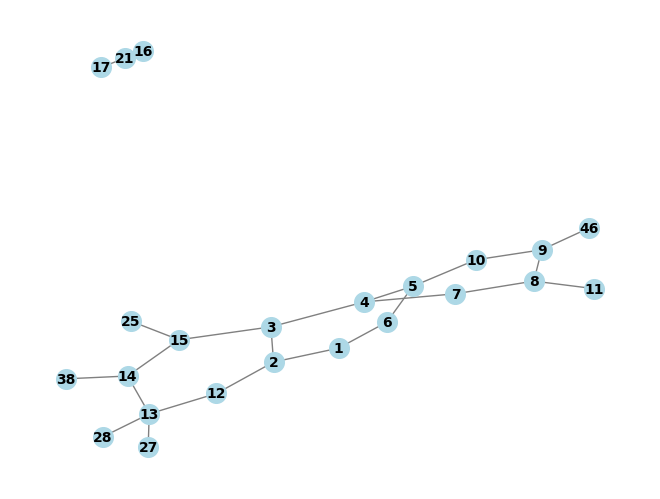

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.01 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.05 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.1 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.2 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.3 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.01 

The loss value is :  [0.31120193004608154] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.05 

The loss value is :  [0.33159366250038147] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.1 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.2 

The loss value is :  [nan] 

Training with learn

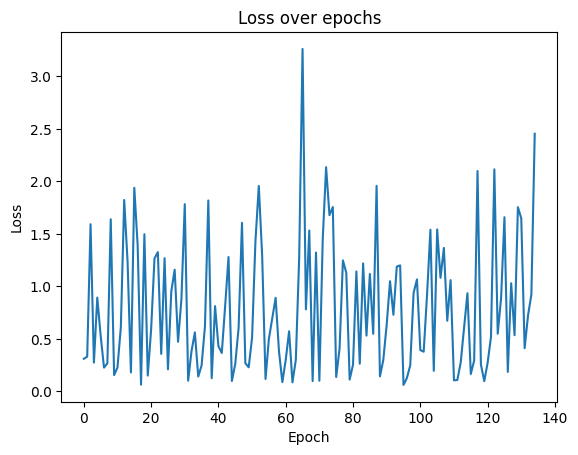

In [8]:
import math
import pandas as pd
import torch
from itertools import product

AIDS = "/content/drive/MyDrive/data/AIDS/"
AIDS_df = pd.read_csv(AIDS + 'AIDS_A.txt', sep=',', header=None, names=['from', 'to'])
AIDS_graph_indicator = pd.read_csv(AIDS + 'AIDS_graph_indicator.txt', header=None, names=['graph_id'])
AIDS_node_labels = pd.read_csv(AIDS + 'AIDS_node_labels.txt', header=None, names=['node_label'])
AIDS_df['graph_id'] = AIDS_graph_indicator
AIDS_df['node_label'] = AIDS_node_labels

grouped = AIDS_df.groupby('graph_id')
AIDS_causal_graphs = {}
for graph_id, group in grouped:
    V = set(group['from']).union(set(group['to']))
    edges = list(zip(group['from'], group['to'])) + list(zip(group['to'], group['from']))
    AIDS_causal_graphs[graph_id] = CausalGraph(V=V, path=edges)

cg = AIDS_causal_graphs[1.0]
v_star, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood = cg.categorize_neighbors(target_node=cg.sort()[0])
print(f"Target node: {v_star}")
print(f"1-hop neighbors of A: {one_hop_neighbors}")
print(f"2-hop neighbors of A: {two_hop_neighbors}")
print(f"Out of neighborhood of A: {out_of_neighborhood}")
cg.plot()

# hyperparameters
num_epochs = 2
learning_rates = [0.001, 0.002, 0.005,0.01]
hidden_sizes = [32, 64, 128, 256]
num_layers = [1, 2, 3, 4]
lambdas = [0.01, 0.05, .1,.2,.3]
hyperparameters = product(learning_rates, hidden_sizes, num_layers, lambdas)
total_loss = []
for i, hyperparams in enumerate(hyperparameters):
    learning_rate, h_size, h_layers, lambdas = hyperparams
    print(f'Training with learning rate: {learning_rate}, h_size: {h_size}, h_layers: {h_layers}, lambdas: {lambdas}','\n')
    causal_loss = train(cg, lambdas, learning_rate, h_size, h_layers, num_epochs)
    total_loss.append(causal_loss)
total_loss = [x for x in total_loss if not math.isnan(x[0])]
print(total_loss)

plt.figure()
plt.plot(total_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.savefig('AIDS NCM Loss over epochs.png')
plt.show()

# MUTAG first graph results

Target node: 1
1-hop neighbors of A: {2, 3, 4}
2-hop neighbors of A: {5, 6, 7, 8}
Out of neighborhood of A: {9}


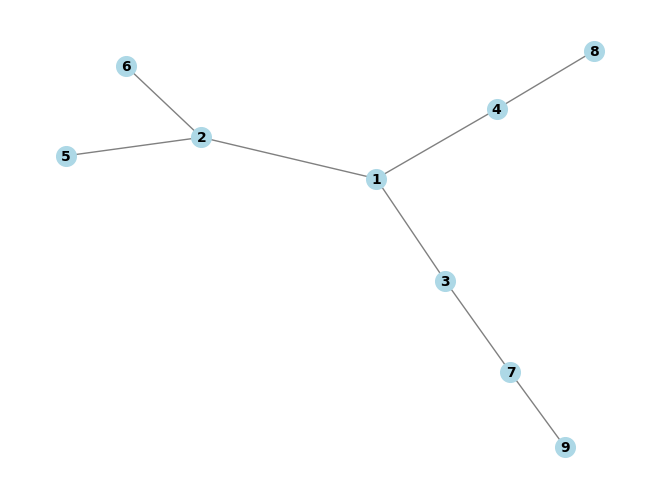

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.01 

The loss value is :  [-0.00021845847368240356] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.05 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.1 

The loss value is :  [0.4095853567123413] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.2 

The loss value is :  [0.5391976237297058] 

Training with learning rate: 0.001, h_size: 32, h_layers: 1, lambdas: 0.3 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.01 

The loss value is :  [nan] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.05 

The loss value is :  [0.4531581997871399] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.1 

The loss value is :  [0.15607568621635437] 

Training with learning rate: 0.001, h_size: 32, h_layers: 2, lambdas: 0.2 


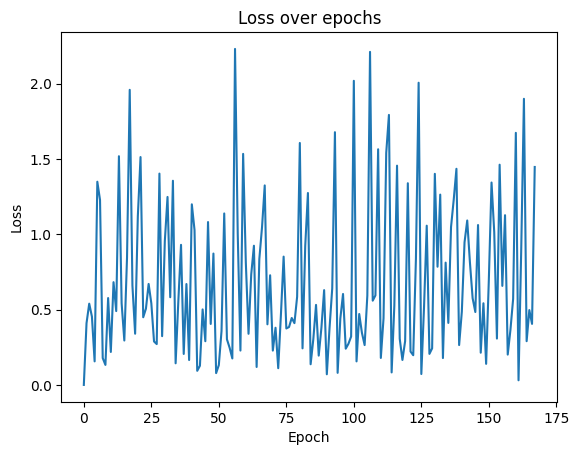

In [9]:
from itertools import product
import pandas as pd

Mutagenicity = "/content/drive/MyDrive/data/Mutagenicity/"
# Load the data
Mutagenicity_df = pd.read_csv(Mutagenicity + 'Mutagenicity_A.txt', sep=',', header=None, names=['from', 'to'])
Mutagenicity_graph_indicator = pd.read_csv(Mutagenicity + 'Mutagenicity_graph_indicator.txt', header=None, names=['graph_id'])
Mutagenicity_node_labels = pd.read_csv(Mutagenicity + 'Mutagenicity_node_labels.txt', header=None, names=['node_label'])
# print(Mutagenicity_edges_df,Mutagenicity_graph_indicator,Mutagenicity_node_labels)
Mutagenicity_df['graph_id'] = Mutagenicity_graph_indicator
Mutagenicity_df['node_label'] = Mutagenicity_node_labels

# Group edges by graph id
grouped = Mutagenicity_df.groupby('graph_id')
# Dictionary to hold each graph
Mutagenicity_causal_graphs = {}
for graph_id, group in grouped:
    # Create a set of vertices for each group
    V = set(group['from']).union(set(group['to']))
    # Create a list of edges for each group
    edges = list(zip(group['from'], group['to'])) + list(zip(group['to'], group['from']))
    # Create a CausalGraph for each group
    Mutagenicity_causal_graphs[graph_id] = CausalGraph(V=V, path=edges)
    # Mutagenicity_causal_graphs[graph_id].plot()

cg = Mutagenicity_causal_graphs[1.0]
v_star, one_hop_neighbors, two_hop_neighbors, out_of_neighborhood = cg.categorize_neighbors(target_node=cg.sort()[0])
print(f"Target node: {v_star}")
print(f"1-hop neighbors of A: {one_hop_neighbors}")
print(f"2-hop neighbors of A: {two_hop_neighbors}")
print(f"Out of neighborhood of A: {out_of_neighborhood}")
cg.plot()

# hyperparameters
num_epochs = 2
learning_rates = [0.001, 0.002, 0.005,0.01]
hidden_sizes = [32, 64, 128, 256]
num_layers = [1, 2, 3, 4]
lambdas = [0.01, 0.05, .1,.2,.3]
hyperparameters = product(learning_rates, hidden_sizes, num_layers, lambdas)
total_loss = []
for i, hyperparams in enumerate(hyperparameters):
    learning_rate, h_size, h_layers, lambdas = hyperparams
    print(f'Training with learning rate: {learning_rate}, h_size: {h_size}, h_layers: {h_layers}, lambdas: {lambdas}','\n')
    causal_loss = train(cg, lambdas, learning_rate, h_size, h_layers, num_epochs)
    total_loss.append(causal_loss)
total_loss = [x for x in total_loss if not math.isnan(x[0])]
print(total_loss)

plt.figure()
plt.plot(total_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.savefig('Mutag NCM Loss over epochs.png')
plt.show()

# GNNCausalExplanation(dataset, num_subgraph_limit, num_nodes_density, delta)